In [292]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
from dataclasses import dataclass
import cantera as ct
from collections import deque

In [293]:
data_path = '/home/elo/CODES/SCI-ML/ember/initial_conditions_uniform_z_100.npz'
data = np.load(data_path)
mech_file = '/home/elo/CODES/SCI-ML/RLIntegratorSelector/large_mechanism/large_mechanism/n-dodecane.yaml'
gas = ct.Solution(mech_file)

In [294]:
phis = data['phi']
Ts = data['T']
Ps = data['P']
Ys = data['Y']

# Reshape 1D arrays to 2D arrays with shape (n,1) before concatenating
phis = phis.reshape(-1,1) 
Ts = Ts.reshape(-1,1)
Ps = Ps.reshape(-1,1)

# combine the phi, T, P, Y into a single array
initial_conditions = np.concatenate([phis, Ts, Ps, Ys], axis=1)

print(initial_conditions.shape)

(1000, 109)


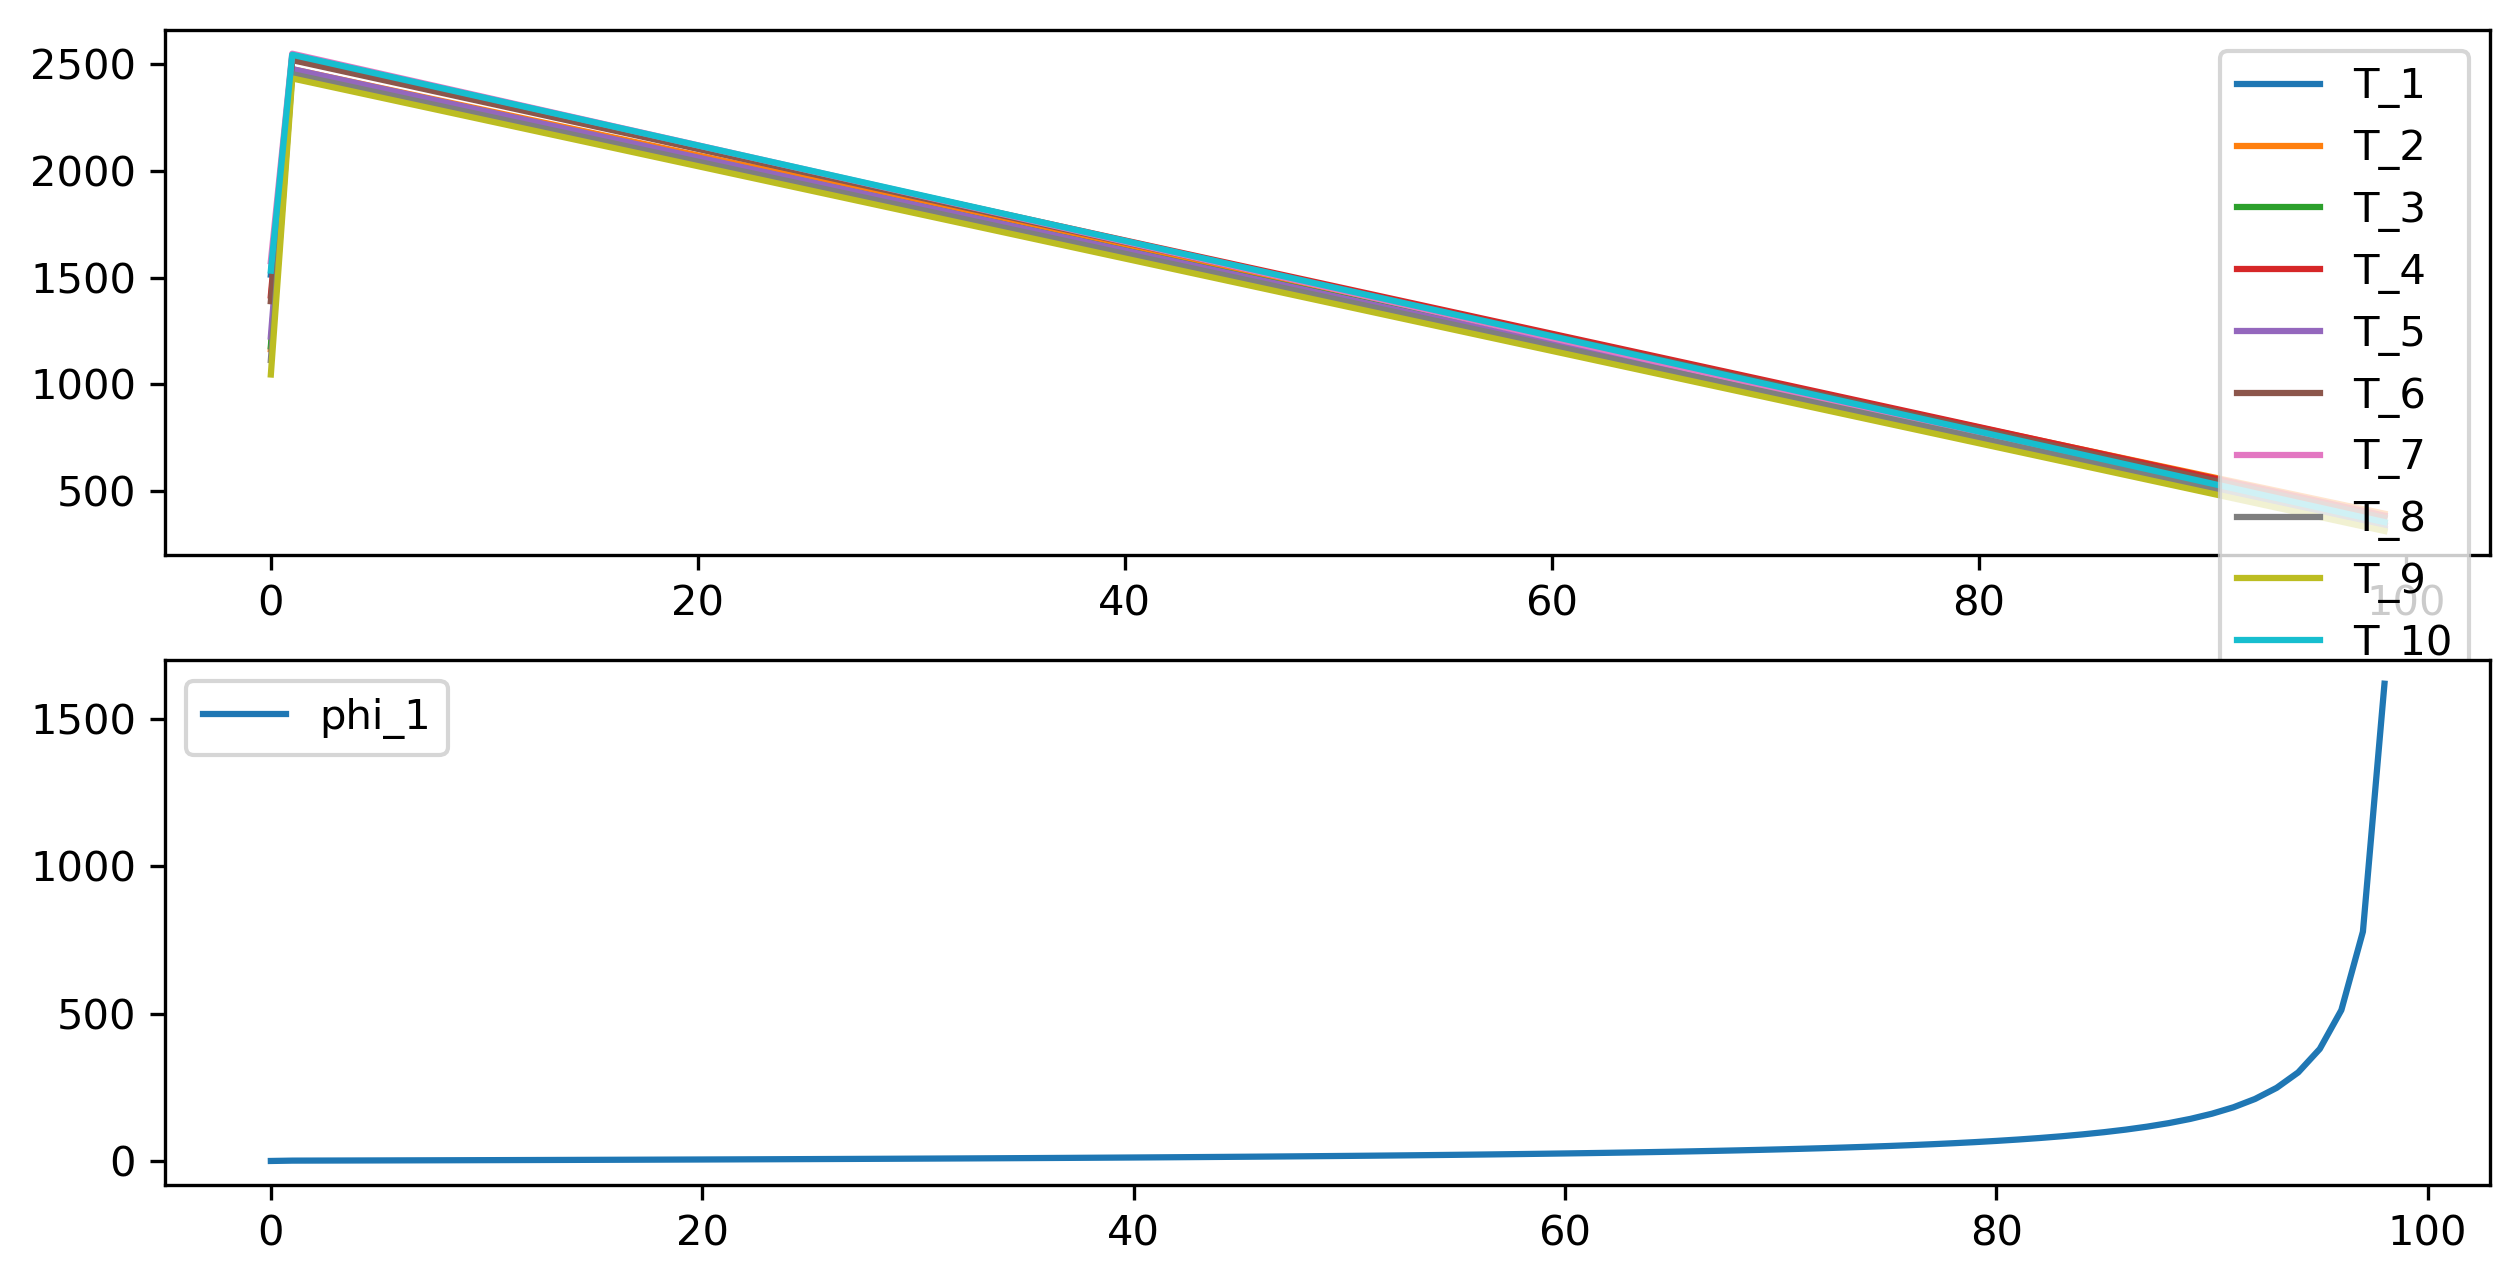

In [295]:
T_1 = Ts[0:100]
T_2 = Ts[100:200]
T_3 = Ts[200:300]
T_4 = Ts[300:400]
T_5 = Ts[400:500]
T_6 = Ts[500:600]
T_7 = Ts[600:700]
T_8 = Ts[700:800]
T_9 = Ts[800:900]
T_10 = Ts[900:1000]


phi_1 = phis[0:100]
phi_2 = phis[100:200]
phi_3 = phis[200:300]
phi_4 = phis[300:400]
phi_5 = phis[400:500]
phi_6 = phis[500:600]
phi_7 = phis[600:700]
phi_8 = phis[700:800]
phi_9 = phis[800:900]
phi_10 = phis[900:1000]


# plot the temperature profiles
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), dpi=300)
ax1.plot(T_1, label='T_1')
ax1.plot(T_2, label='T_2')
ax1.plot(T_3, label='T_3')
ax1.plot(T_4, label='T_4')
ax1.plot(T_5, label='T_5')
ax1.plot(T_6, label='T_6')
ax1.plot(T_7, label='T_7')
ax1.plot(T_8, label='T_8')
ax1.plot(T_9, label='T_9')
ax1.plot(T_10, label='T_10')
ax1.legend()

ax2.plot(phi_1, label='phi_1')
# ax2.plot(phi_2, label='phi_2')
# ax2.plot(phi_3, label='phi_3')
# ax2.plot(phi_4, label='phi_4')
# ax2.plot(phi_5, label='phi_5')
# ax2.plot(phi_6, label='phi_6')
# ax2.plot(phi_7, label='phi_7')
# ax2.plot(phi_8, label='phi_8')
# ax2.plot(phi_9, label='phi_9')
# ax2.plot(phi_10, label='phi_10')
ax2.legend()
plt.show()




In [264]:
# Print shapes for debugging
print("Shape of initial_conditions:", initial_conditions.shape)  # (100000, 109)
print("Shape of phis:", phis.shape)  # (100000, 1)

# Create boolean mask for valid phi values
phi_mask = np.logical_and(phis >= 0.1, phis <= 1000)
phi_mask = phi_mask.flatten()  # Convert from (100000, 1) to (100000,)

# Apply mask to filter initial conditions
initial_conditions_filtered = initial_conditions[phi_mask]
print("Shape of filtered conditions:", initial_conditions_filtered.shape)

Shape of initial_conditions: (100000, 109)
Shape of phis: (100000, 1)
Shape of filtered conditions: (54595, 109)


In [296]:
# check the minimum and maximum of phi and temperature
print(f"Minimum phi: {np.min(initial_conditions_filtered[:,0])}")
print(f"Maximum phi: {np.max(initial_conditions_filtered[:,0])}")
print(f"Minimum temperature: {np.min(initial_conditions_filtered[:,1])}")
print(f"Maximum temperature: {np.max(initial_conditions_filtered[:,1])}")



Minimum phi: 0.10003515163666683
Maximum phi: 999.8825927195783
Minimum temperature: 339.0888480365761
Maximum temperature: 2492.5776764140837


In [297]:

def parse_composition(gas, X):
    """create a dictionary of species:fraction pairs from the gas species names and X."""
    species_names = gas.species_names
    composition = {}
    for i, species in enumerate(species_names):
        composition[species] = X[i]
    return composition


def check_steady_state(temperature_queue, initial_temperature, tolerance=0.1, increase_factor=1.2):
    """Check if steady state is reached based on temperature standard deviation and change from initial.
    
    Args:
        temperature_queue: Queue containing recent temperature values
        initial_temperature: Initial temperature of the system
        tolerance: Maximum allowed standard deviation of temperatures
        temp_change_threshold: Maximum allowed fractional change from initial temperature
        
    Returns:
        bool: True if steady state is reached, False otherwise
    """
    if len(temperature_queue) < 10:
        return False
        
    mean_temperature = np.mean(temperature_queue)
    std_temperature = np.std(temperature_queue)
    
    if mean_temperature > increase_factor*initial_temperature and std_temperature < tolerance:
        return True
    else:
        return False
    


In [362]:
condition = initial_conditions_filtered[np.random.randint(0, len(initial_conditions_filtered))]
fuel = 'ch4'
oxidizer = 'o2'
phi = condition[0]
initial_mixture = f"{fuel}:1, {oxidizer}"
cleaned_Xs = parse_composition(gas, condition[3:])
gas.TP = condition[1], condition[2]
gas.X = cleaned_Xs
gas.set_equivalence_ratio(phi, fuel, oxidizer)

print(f"Temperature: {condition[1]} K")
print(f"Pressure: {condition[2]} Pa")
print(f"Equivalence ratio: {phi}")

reactor = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([reactor])
sim.rtol = 1e-10
sim.atol = 1e-20

Temperature: 1773.8460765650084 K
Pressure: 101325.0 Pa
Equivalence ratio: 0.5257169072293792


In [363]:
temperatures = []
pressures = []
times = []
species_profiles = {spec: [] for spec in gas.species_names}
dt = 1e-5
t = 0.0
t_end = 1e-1
steady_state_reached = False

ideal_num_steps = (t_end - t) / dt
# create a fixed size queue of 5 temperatures
temperature_queue = deque(maxlen=10)
initial_temperature = reactor.T
while t < t_end:
    previous_state = reactor.thermo.state
    sim.advance(t)
    times.append(t)
    temperatures.append(reactor.T)
    temperature_queue.append(reactor.T)
    pressures.append(reactor.thermo.P)
    for spec in gas.species_names:
        species_profiles[spec].append(reactor.thermo[spec].Y)

    if check_steady_state(temperature_queue, initial_temperature):
        steady_state_reached = True
        break
        
    t += dt

if steady_state_reached:
    print(f"Steady state reached after {len(times)} steps of {ideal_num_steps}")
else:
    print(f"Steady state not reached after {len(times)} steps of {ideal_num_steps}")


Steady state reached after 17 steps of 10000.0


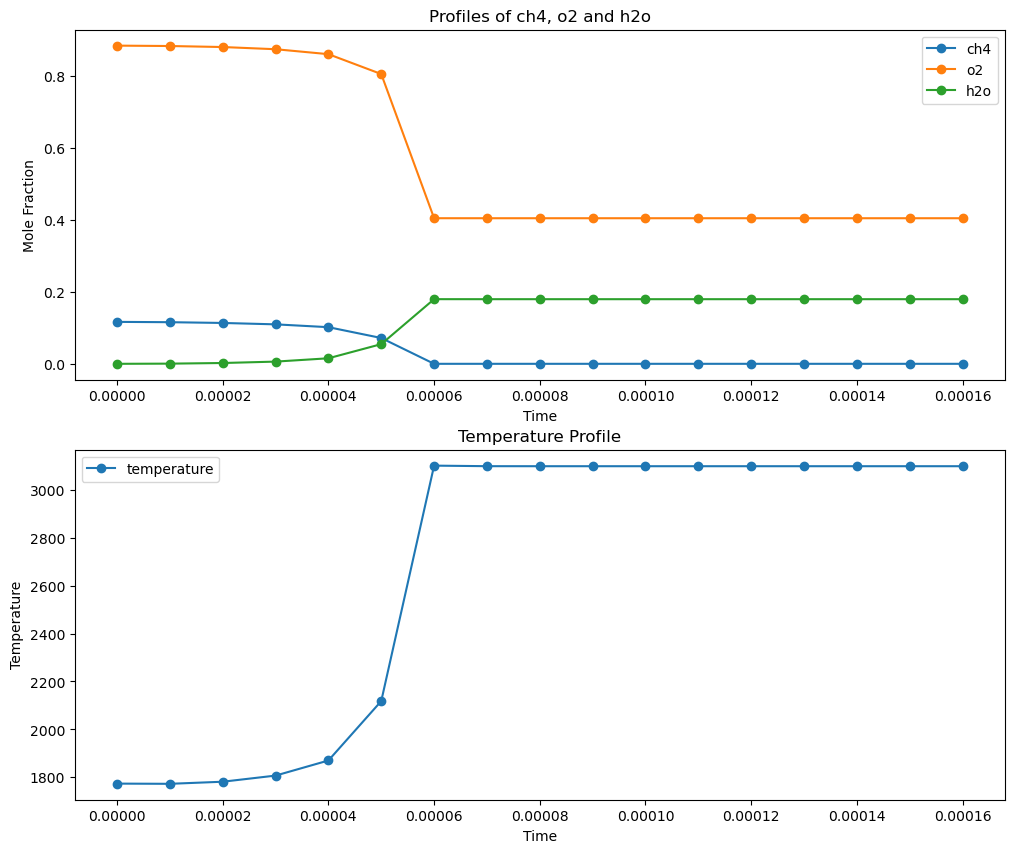

In [364]:
# plot the ch4, o2 and h2o profiles
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(times, species_profiles['ch4'], 'o-', label='ch4')
ax1.plot(times, species_profiles['o2'], 'o-', label='o2')
ax1.plot(times, species_profiles['h2o'], 'o-', label='h2o')
ax1.legend()
ax1.set_title('Profiles of ch4, o2 and h2o')
ax1.set_xlabel('Time')
ax1.set_ylabel('Mole Fraction')

# plot the temperature profile
ax2.plot(times, temperatures, 'o-', label='temperature')
ax2.legend()
ax2.set_title('Temperature Profile')
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature')

plt.show()





Testing condition 0:
Temperature: 1986.037696548005 K
Pressure: 101325.0 Pa
Phi: 1.2561113260365406
Sum of mole fractions: 1.0
Maximum temperature change: 352.9748272027068 K
This condition is REACTIVE

Testing condition 1:
Temperature: 1602.119767603972 K
Pressure: 101325.0 Pa
Phi: 0.9632077538549194
Sum of mole fractions: 1.0000000000000002
Maximum temperature change: 356.75745642442735 K
This condition is REACTIVE

Testing condition 2:
Temperature: 1949.089456307126 K
Pressure: 101325.0 Pa
Phi: 1.2561113260382588
Sum of mole fractions: 0.9999999999999999
Maximum temperature change: 349.22913240300204 K
This condition is REACTIVE

Testing condition 3:
Temperature: 2071.2465111837037 K
Pressure: 101325.0 Pa
Phi: 0.6916209264700773
Sum of mole fractions: 1.0
Maximum temperature change: 63.29323304693753 K
This condition is REACTIVE

Testing condition 4:
Temperature: 1940.5383261768445 K
Pressure: 101325.0 Pa
Phi: 1.2561113260414842
Sum of mole fractions: 0.9999999999999999
Maximum tem

/tmp/ipykernel_1549992/2076282601.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


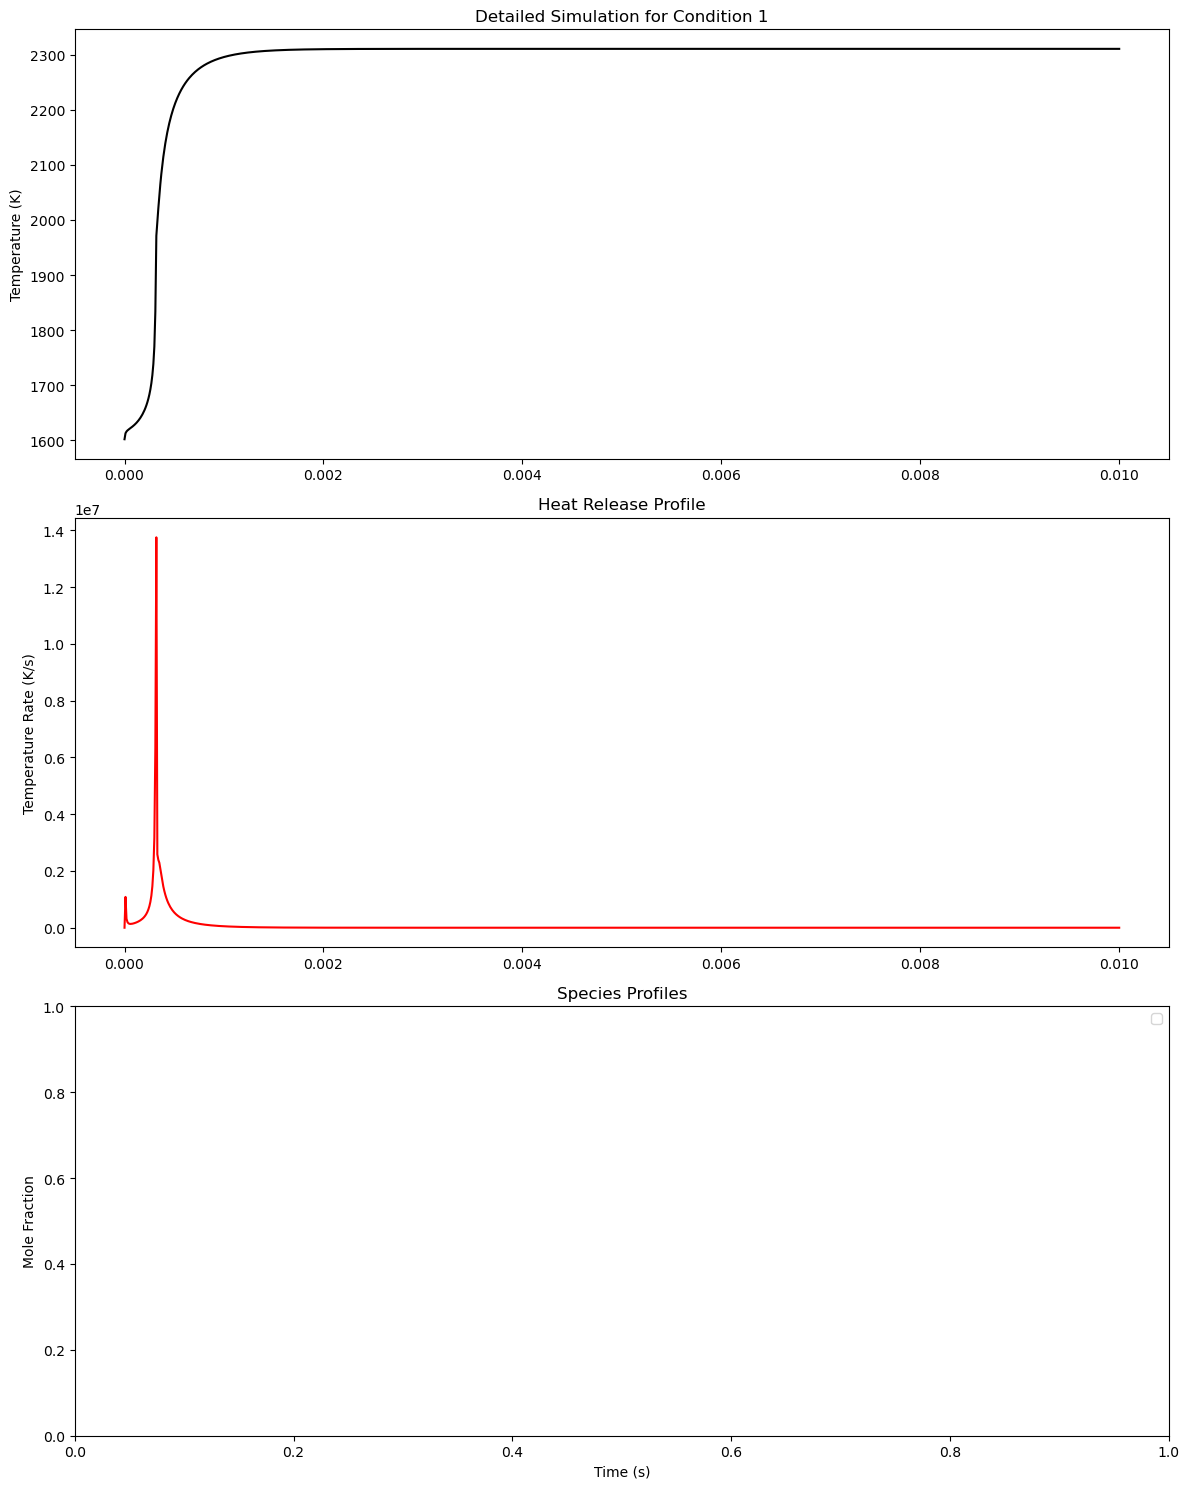

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
from tqdm import tqdm
import random

# Load initial conditions
initial_condition_data = 'initial_conditions_from_1d.pkl'
with open(initial_condition_data, 'rb') as f:
    initial_conditions = pickle.load(f)

# Path to mechanism file
mech_file = '/home/elo/CODES/SCI-ML/RLIntegratorSelector/large_mechanism/large_mechanism/n-dodecane.yaml'
gas = ct.Solution(mech_file)

# Helper function to properly parse composition strings


# Test multiple initial conditions to find ones that react
reactive_conditions = []
non_reactive_conditions = []

# Test a batch of conditions (limit to 20 for quick testing)
# get random 20 conditions
points = [47, 48, 49, 50, 51, 52, 53, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950]
random_conditions = []
for point in points:
    random_conditions.append(initial_conditions[point])

for idx, condition in enumerate(random_conditions):
    try:
        print(f"\nTesting condition {idx}:")
        print(f"Temperature: {condition['T']} K")
        print(f"Pressure: {condition['P']} Pa")
        print(f"Phi: {condition['metadata']['phi']}")
        
        # Parse composition properly
        composition = parse_composition(condition['X'])
        
        # Set up the gas and reactor
        gas.TPX = condition['T'], condition['P'], composition
        
        # Make sure the composition was set correctly
        print(f"Sum of mole fractions: {sum(gas.X)}")
        
        # Create reactor simulation
        reactor = ct.IdealGasConstPressureReactor(gas)
        sim = ct.ReactorNet([reactor])
        sim.rtol = 1e-6
        sim.atol = 1e-15
        
        # Run the simulation
        times = []
        temperatures = []
        ch4_fractions = []
        o2_fractions = []
        h2o_fractions = []
        
        t = 0.0
        t_end = 1e-2
        dt = 1e-4
        
        # Run for a short time to see if it reacts
        max_temp_change = 0
        
        while t < t_end:
            initial_temp = reactor.T
            sim.advance(t)
            final_temp = reactor.T
            
            # Track maximum temperature change
            delta_T = abs(final_temp - initial_temp)
            max_temp_change = max(max_temp_change, delta_T)
            
            times.append(t)
            temperatures.append(reactor.T)
            try:
                ch4_idx = gas.species_index('CH4')
                ch4_fractions.append(reactor.thermo.X[ch4_idx])
            except ValueError:
                ch4_fractions.append(0)
                
            try:    
                o2_idx = gas.species_index('O2')
                o2_fractions.append(reactor.thermo.X[o2_idx])
            except ValueError:
                o2_fractions.append(0)
                
            try:
                h2o_idx = gas.species_index('H2O')
                h2o_fractions.append(reactor.thermo.X[h2o_idx])
            except ValueError:
                h2o_fractions.append(0)
                
            t += dt
        
        # Check if this condition is reactive
        print(f"Maximum temperature change: {max_temp_change} K")
        if max_temp_change > 10:  # If temperature changes by at least 10K
            print("This condition is REACTIVE")
            reactive_conditions.append((idx, condition, max_temp_change))
        else:
            print("This condition is NON-REACTIVE")
            non_reactive_conditions.append((idx, condition, max_temp_change))
        
        # Plot the results for this condition
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Species plot
        ax1.plot(times, ch4_fractions, 'b-', label='CH4')
        ax1.plot(times, o2_fractions, 'r-', label='O2')
        ax1.plot(times, h2o_fractions, 'g-', label='H2O')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Mole Fraction')
        ax1.set_title(f'Profiles for condition {idx} (T={condition["T"]:.1f}K, phi={condition["metadata"]["phi"]:.2f})')
        ax1.legend()
        
        # Temperature plot
        ax2.plot(times, temperatures, 'k-')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Temperature (K)')
        ax2.set_title('Temperature Profile')
        
        plt.tight_layout()
        plt.savefig(f'condition_{idx}_test.png')
        plt.close()
        
    except Exception as e:
        print(f"Error testing condition {idx}: {e}")
        continue

# Print summary of reactive vs non-reactive conditions
print("\n--- Summary ---")
print(f"Tested {len(reactive_conditions) + len(non_reactive_conditions)} conditions")
print(f"Reactive conditions: {len(reactive_conditions)}")
print(f"Non-reactive conditions: {len(non_reactive_conditions)}")

if reactive_conditions:
    print("\nTop 5 most reactive conditions:")
    # Sort by temperature change
    reactive_conditions.sort(key=lambda x: x[2], reverse=True)
    for i, (idx, condition, temp_change) in enumerate(reactive_conditions[:5]):
        print(f"{i+1}. Condition {idx}: T={condition['T']:.1f}K, phi={condition['metadata']['phi']:.2f}, ΔT={temp_change:.1f}K")

# Select the most reactive condition for detailed plotting
if reactive_conditions:
    best_idx, best_condition, _ = reactive_conditions[0]
    print(f"\nPlotting detailed simulation for most reactive condition ({best_idx})...")
    
    # Re-run the simulation for the best condition with more output
    composition = parse_composition(best_condition['X'])
    gas.TPX = best_condition['T'], best_condition['P'], composition
    
    reactor = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([reactor])
    sim.rtol = 1e-6
    sim.atol = 1e-15
    
    times = []
    temperatures = []
    heat_release_rates = []
    species_profiles = {}
    
    # Track important species
    tracked_species = ['CH4', 'O2', 'H2O', 'CO', 'CO2', 'OH', 'H2O2', 'HO2']
    for spec in tracked_species:
        if spec in gas.species_names:
            species_profiles[spec] = []
    
    t = 0.0
    t_end = 1e-2
    dt = 1e-5  # More detailed output
    
    while t < t_end:
        sim.advance(t)
        times.append(t)
        temperatures.append(reactor.T)
        
        # Calculate heat release rate (could be useful)
        if len(times) > 1:
            dT = temperatures[-1] - temperatures[-2]
            dt_actual = times[-1] - times[-2]
            heat_release_rates.append(dT/dt_actual if dt_actual > 0 else 0)
        else:
            heat_release_rates.append(0)
        
        # Track species
        for spec in species_profiles:
            try:
                idx = gas.species_index(spec)
                species_profiles[spec].append(reactor.thermo.X[idx])
            except ValueError:
                species_profiles[spec].append(0)
        
        t += dt
    
    # Create detailed plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Temperature
    ax1.plot(times, temperatures, 'k-')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title(f'Detailed Simulation for Condition {best_idx}')
    
    # Heat release rate
    ax2.plot(times[:], heat_release_rates, 'r-')
    ax2.set_ylabel('Temperature Rate (K/s)')
    ax2.set_title('Heat Release Profile')
    
    # Species
    for spec, profile in species_profiles.items():
        ax3.plot(times, profile, label=spec)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Mole Fraction')
    ax3.set_title('Species Profiles')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(f'best_condition_{best_idx}_detailed.png')
    plt.show()